In [ ]:
# #TODO:
# # ...# normalize telephone number using existing python libraries
# try different jaccard threshold score for second check

In [1]:
#!pip install rank-bm25
from rank_bm25 import BM25Okapi
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from os import listdir
from os.path import isfile, join
import re
import numpy as np
from math import floor, ceil

In [2]:
# decompress the gz files 
# experiment with entity type: local business

source_path = r"C:\Users\chench10\Downloads\Local Business_LDFiltered"
target_path = r"C:\Users\chench10\Downloads\Local Business_LDFiltered_unpressed"
gzfiles = os.listdir(source_path) 

for file in gzfiles: 
    if not file.endswith('.gz'):
        continue
    with gzip.open( os.path.join(source_path, file), "rb") as f_in:
        with open(os.path.join(target_path, file.rstrip('.gz')), 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

In [3]:
# get all LB data
source_path = r"C:\Users\chench10\Downloads\Local Business\LocalBuisness_top100"
all_files = os.listdir(source_path)

df_all = pd.DataFrame()
for file in all_files:
    df = pd.read_json(os.path.join(source_path, file), compression='gzip', lines=True)
    df['table id'] = file.strip('.json.gz')
    df_all = pd.concat([df_all, df], ignore_index=True)

In [4]:
# get all filtered LB data
source_path = r"C:\Users\chench10\Downloads\Local Business_LDFiltered"
all_files = os.listdir(source_path)

df_filtered = pd.DataFrame()
for file in all_files:
    df = pd.read_json(os.path.join(source_path, file), compression='gzip', lines=True)
    df['table id'] = file.strip('.json.gz')
    df_filtered = pd.concat([df_filtered, df], ignore_index=True)

In [5]:
df_all = df_all.drop(columns=['row_id'], axis=0)
df_filtered = df_filtered.drop(columns=['row_id'], axis=0)
df_all.columns

Index(['name', 'address', 'telephone', 'page_url', 'table id',
       'aggregaterating', 'email', 'geo', 'url', 'image',
       'openinghoursspecification', 'faxnumber', 'review', 'logo',
       'datemodified', 'contactpoint', 'areaserved', 'legalname', 'pricerange',
       'hasmap', 'description', 'branchof', 'sameas', 'taxid',
       'addresslocality', 'photo', 'reviewbody', 'price', 'serialnumber',
       'openinghours', 'alternatename', 'vatid', 'currenciesaccepted',
       'paymentaccepted', 'brand', 'publicaccess', 'hasoffercatalog', 'fax',
       'interactioncount', 'event', 'streetaddress', 'postalcode', 'location',
       'employee', 'knowsabout'],
      dtype='object')

In [7]:
# statistics of all LB data
na_data_sum = df_all.isna().sum()
na_data_per = na_data_sum/len(df_all)

df_all_stats = pd.DataFrame({"na_sum":na_data_sum, "na_percent": na_data_per})
num_obs = len(df_all)

df_all_stats["sum"] = num_obs - df_all_stats["na_sum"]
df_all_stats["percent"] = 1 - df_all_stats["na_percent"]
df_all_stats['parent'] = 'Before Cleaning'
display(df_all_stats.sort_values("na_percent", ascending=True).head(10))

,na_sum,na_percent,sum,percent,parent
page_url,0,0.000000,1114508,1.000000,Before Cleaning
table id,0,0.000000,1114508,1.000000,Before Cleaning
name,13590,0.012194,1100918,0.987806,Before Cleaning
address,147843,0.132653,966665,0.867347,Before Cleaning
telephone,426696,0.382856,687812,0.617144,Before Cleaning
geo,701824,0.629716,412684,0.370284,Before Cleaning
description,775963,0.696238,338545,0.303762,Before Cleaning
aggregaterating,778974,0.698940,335534,0.301060,Before Cleaning
url,838182,0.752065,276326,0.247935,Before Cleaning
pricerange,913600,0.819734,200908,0.180266,Before Cleaning


In [8]:
# statistics of all filtered LB data
na_data_sum = df_filtered.isna().sum()
na_data_per = na_data_sum/len(df_filtered)

df_filtered_stats = pd.DataFrame({"na_sum":na_data_sum, "na_percent": na_data_per})
num_obs = len(df_filtered)

df_filtered_stats["sum"] = num_obs - df_filtered_stats["na_sum"]
df_filtered_stats["percent"] = 1 - df_filtered_stats["na_percent"]
df_filtered_stats['parent'] = 'After Cleaning'
display(df_filtered_stats.sort_values("na_percent", ascending=True).head(10))

,na_sum,na_percent,sum,percent,parent
page_url,0,0.000000,215069,1.000000,After Cleaning
table id,0,0.000000,215069,1.000000,After Cleaning
name,369,0.001716,214700,0.998284,After Cleaning
address,69118,0.321376,145951,0.678624,After Cleaning
description,134183,0.623907,80886,0.376093,After Cleaning
aggregaterating,134671,0.626176,80398,0.373824,After Cleaning
telephone,141875,0.659672,73194,0.340328,After Cleaning
geo,149112,0.693322,65957,0.306678,After Cleaning
url,165590,0.769939,49479,0.230061,After Cleaning
review,176304,0.819756,38765,0.180244,After Cleaning


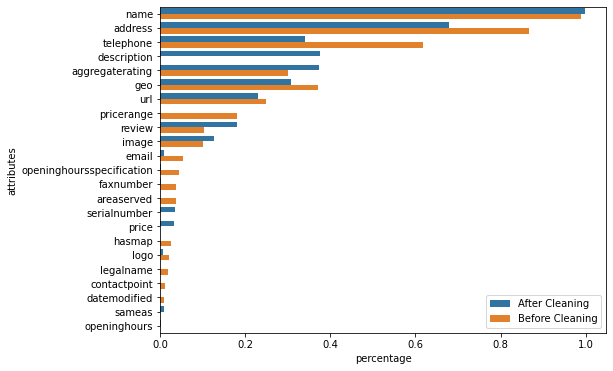

In [9]:
# concatenate two statistic files and plot
df_all_stats_1 = df_all_stats.iloc[0:20]
df_filtered_stats_1 = df_filtered_stats.iloc[0:20]

data_lb_1 = pd.concat([df_all_stats_1.drop(index=['page_url','table id'], axis=1), 
                     df_filtered_stats_1.drop(index=['page_url','table id'], axis=1)], 
                    axis=0).sort_values('percent', ascending=False)

# visualize the result
plt.figure(figsize=(8,6))
# plt.barh(data_lb.drop(index=['page_url','table id'], axis=1).index, 
#          width=data_lb.drop(index=['page_url','table id'], axis=0)['percent_all'], height=0.5)

# plt.barh(data_lb.drop(index=['page_url','table id'], axis=1).index, 
#          width=data_lb.drop(index=['page_url','table id'], axis=0)['percent_filtered'], height=0.5)

ax = sns.barplot(x='percent', y=data_lb_1.index, data=data_lb_1, hue='parent')
plt.ylabel("attributes")
plt.xlabel("percentage")
plt.legend(loc='lower right')

### Play with Geo

In [19]:
df_geo = df_filtered[~df_filtered['geo'].isna()]
df_geo.iloc[0]['geo']['latitude']

'58.42267'

In [20]:
df_geo['geo']

6731      {'longitude': '-4.37451', 'latitude': '58.42267'}
6812      {'latitude': '47.44147', 'longitude': '11.76363'}
7035      {'longitude': '-79.71204', 'latitude': '32.9254'}
7043      {'longitude': '35.24864', 'latitude': '32.35277'}
7197      {'longitude': '44.43549', 'latitude': '40.50881'}
                                ...                        
215058    {'latitude': '50.42922311220', 'longitude': '3...
215064    {'latitude': '50.39292900000', 'longitude': '3...
215066    {'latitude': '50.42049900000', 'longitude': '3...
215067                  {'longitude': '0', 'latitude': '0'}
215068                  {'longitude': '0', 'latitude': '0'}
Name: geo, Length: 65957, dtype: object

In [21]:
# geo preprocessing
def get_longitude(iterator):
    if isinstance(iterator, dict): 
        return iterator.get('longitude', '')
    elif isinstance(iterator, list): 
        return ''

def get_latitude(iterator):
    if isinstance(iterator, dict): 
        return iterator.get('latitude', '')
    elif isinstance(iterator, list): 
        return ''

df_geo['longitude']=df_geo['geo'].apply(get_longitude)
df_geo['latitude']=df_geo['geo'].apply(get_latitude)

filter_1 = ((df_geo['longitude']!='0')&(df_geo['latitude']!='0'))
filter_2 = ((df_geo['longitude']!='')&(df_geo['latitude']!=''))

df_geo_filtered = df_geo[filter_1&filter_2]
df_geo_filtered.head()

<ipython-input-21-b1d7683818a2>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_geo['longitude']=df_geo['geo'].apply(get_longitude)
<ipython-input-21-b1d7683818a2>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_geo['latitude']=df_geo['geo'].apply(get_latitude)


,name,address,telephone,page_url,table id,aggregaterating,email,geo,url,image,...,fax,interactioncount,hasoffercatalog,paymentaccepted,currenciesaccepted,brand,knowsabout,legalname,longitude,latitude
6731,Achnanclach Bothy,NaN,NaN,https://www.alltrails.com/trail/scotland/highl...,LocalBusiness_alltrails.com_September2020,"{'worstrating': '0', 'reviewcount': '0', 'best...",NaN,"{'longitude': '-4.37451', 'latitude': '58.42267'}",NaN,"Achnanclach Bothy easy Braetongue , Highland, ...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-4.37451,58.42267
6812,Achensee Rofan,NaN,NaN,https://www.alltrails.com/trail/austria/tyrol/...,LocalBusiness_alltrails.com_September2020,"{'worstrating': '0', 'reviewcount': '0', 'best...",NaN,"{'latitude': '47.44147', 'longitude': '11.76363'}",NaN,https://cdn-assets.alltrails.com/uploads/photo...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.76363,47.44147
7035,After the Bridge Run Ride,NaN,NaN,https://www.alltrails.com/trail/us/south-carol...,LocalBusiness_alltrails.com_September2020,"{'worstrating': '0', 'reviewcount': '0', 'best...",NaN,"{'longitude': '-79.71204', 'latitude': '32.9254'}",NaN,After the Bridge Run Ride moderate Francis Mar...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-79.71204,32.9254
7043,Abraham Path: Sanur to Sebastiya,NaN,NaN,https://www.alltrails.com/trail/palestine/west...,LocalBusiness_alltrails.com_September2020,"{'worstrating': '0', 'reviewcount': '0', 'best...",NaN,"{'longitude': '35.24864', 'latitude': '32.35277'}",NaN,https://cdn-assets.alltrails.com/uploads/photo...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.24864,32.35277
7197,"Best Bird Watching Trails in Aragatsotn, Armenia",NaN,NaN,https://www.alltrails.com/armenia/aragatsotn/b...,LocalBusiness_alltrails.com_September2020,"{'worstrating': '0', 'ratingvalue': '5.0', 'be...",NaN,"{'longitude': '44.43549', 'latitude': '40.50881'}",NaN,https://cdn-assets.alltrails.com/uploads/photo...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44.43549,40.50881


In [22]:
df_geo_grouped = df_geo_filtered.groupby(['latitude','longitude']).count().sort_values('table id', ascending=False).reset_index()
df_geo_grouped

,latitude,longitude,name,address,telephone,page_url,table id,aggregaterating,email,geo,...,areaserved,pricerange,fax,interactioncount,hasoffercatalog,paymentaccepted,currenciesaccepted,brand,knowsabout,legalname
0,3.238251,6.5466094,228,228,228,228,228,0,0,228,...,0,0,0,0,0,0,0,0,0,0
1,3.3792,6.5244,147,147,147,147,147,0,0,147,...,0,0,0,0,0,0,0,0,0,0
2,3.3514863,6.601838,140,140,140,140,140,0,0,140,...,0,0,0,0,0,0,0,0,0,0
3,3.1578875,6.4619141,139,139,139,139,139,0,0,139,...,0,0,0,0,0,0,0,0,0,0
4,3.3439291,6.4979884,133,133,133,133,133,0,0,133,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45028,3.563718E1,-8.151328E1,1,1,1,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
45029,3.56377E1,-7.847089E1,1,1,1,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
45030,3.56381037E1,1.395700153E2,1,1,0,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
45031,3.563942E1,-7.946693E1,1,1,1,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0


Text(0, 0.5, 'num of cluster id')

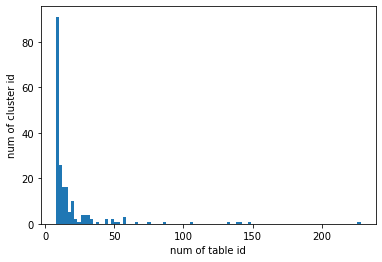

In [16]:
# plot histogram of geo-matched entities
distribution = df_geo_grouped['table id']
plt.hist(distribution[:200], bins=100)

plt.xlabel('num of table id')
plt.ylabel('num of cluster id')

In [24]:
df_geo_filtered[(df_geo_filtered['latitude']=='3.238251') & (df_geo_filtered['longitude']=='6.5466094')]

,name,address,telephone,page_url,table id,aggregaterating,email,geo,url,image,...,fax,interactioncount,hasoffercatalog,paymentaccepted,currenciesaccepted,brand,knowsabout,legalname,longitude,latitude
176924,"Dami Panel Beater in 2Nd Ave, 21, 2Nd Ave, 21,...","{'addresslocality': 'Nicon Bus Stop', 'streeta...",7033844497.0,https://www.vconnect.com/dami-panel-beater-ali...,LocalBusiness_vconnect.com_September2020,NaN,NaN,"{'latitude': '3.238251', 'longitude': '6.54660...",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.5466094,3.238251
177071,Dakchi Camera in Babagunwa Street Ayobo Alimos...,"{'streetaddress': ', Babagunwa Street Ayobo Al...",7036579705.0,https://www.vconnect.com/dakchi-camera-alimosh...,LocalBusiness_vconnect.com_September2020,NaN,NaN,"{'latitude': '3.238251', 'longitude': '6.54660...",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.5466094,3.238251
177085,"Damlat Faith Clinic in 16, 16, Alame Obadina S...","{'streetaddress': '16, 16, Alame Obadina Stree...",8020771335.0,https://www.vconnect.com/damlat-faith-clinic-a...,LocalBusiness_vconnect.com_September2020,NaN,NaN,"{'latitude': '3.238251', 'longitude': '6.54660...",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.5466094,3.238251
177116,"Darootz Entertainment in 12, 12, Omoniyi Fasha...","{'addresslocality': 'Aboru Estate', 'streetadd...",8029030711.0,https://www.vconnect.com/darootz-entertainment...,LocalBusiness_vconnect.com_September2020,NaN,NaN,"{'latitude': '3.238251', 'longitude': '6.54660...",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.5466094,3.238251
177242,"Cowrie Crown Nigeria Limited in 5, 5, Ibrahim ...","{'addresslocality': 'Ikotun', 'streetaddress':...",8033013083.0,https://www.vconnect.com/cowrie-crown-nigeria-...,LocalBusiness_vconnect.com_September2020,NaN,NaN,"{'latitude': '3.238251', 'longitude': '6.54660...",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.5466094,3.238251
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191492,"Da Twins Frozen Food in 1, 1, Gbagada Road, Ne...","{'addresslocality': 'Gbagada', 'addressregion'...",8028445887.0,https://www.vconnect.com/da-twins-frozen-food-...,LocalBusiness_vconnect.com_September2020,NaN,NaN,"{'latitude': '3.238251', 'longitude': '6.54660...",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.5466094,3.238251
191609,"Damty Rentals And Fashion Designer in 11, 11, ...","{'addresslocality': 'Ikotun', 'streetaddress':...",8033160320.0,https://www.vconnect.com/damty-rentals-and-fas...,LocalBusiness_vconnect.com_September2020,NaN,NaN,"{'latitude': '3.238251', 'longitude': '6.54660...",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.5466094,3.238251
191621,"Da'cream Unisex Saloon in Shop 28, Shop 28, So...","{'addresslocality': 'Egbeda', 'streetaddress':...",8025760359.0,https://www.vconnect.com/da-cream-unisex-saloo...,LocalBusiness_vconnect.com_September2020,NaN,NaN,"{'latitude': '3.238251', 'longitude': '6.54660...",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.5466094,3.238251
191671,"Datfad Cosmetics And Gas in 88, 88, Alhaja Roa...","{'addresslocality': 'Ipaja Ayobo', 'addressreg...",802316615.0,https://www.vconnect.com/datfad-cosmetics-and-...,LocalBusiness_vconnect.com_September2020,NaN,NaN,"{'latitude': '3.238251', 'longitude': '6.54660...",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.5466094,3.238251


seems that geo is not a good identifier in this case

### Play with telephone number

In [28]:
df_tel = df_filtered[~df_filtered['telephone'].isna()]
df_tel.iloc[0]['telephone']

'(781) 885-3244'

In [29]:
def normalizer(telephone):    # reference: slides of Web Data Integration: 04 Identity Resolution
    return ''.join(re.findall('[1-9]+', telephone))
 
df_tel['telephone_new'] = df_tel['telephone'].astype('str').apply(normalizer)

#TODO: 
# try to normalize telephone number using existing python libraries, probably can also use info 
#    from address/geo for parsing country code
# more steps for cleaning            

<ipython-input-29-1c476fa92dc3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tel['telephone_new'] = df_tel['telephone'].astype('str').apply(normalizer)


In [49]:
df_tel_filtered = df_tel[(~df_tel['telephone_new'].isin([''])) & (len(df_tel['telephone_new']) >= 3)]
df_tel_filtered.head(10)

,name,address,telephone,page_url,table id,aggregaterating,email,geo,url,image,...,pricerange,fax,interactioncount,hasoffercatalog,paymentaccepted,currenciesaccepted,brand,knowsabout,legalname,telephone_new
0,Law Office of Donald E Green,"{'addressregion': 'MA', 'postalcode': '02368',...",(781) 885-3244,https://101attorney.com/attorney_finder/ma_oth...,LocalBusiness_101attorney.com_September2020,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7818853244
1,The Law Offices Of Joshua F Pompilus Pc,"{'streetaddress': '490 N Main Street', 'addres...",(781) 986-1124,https://101attorney.com/attorney_finder/ma_oth...,LocalBusiness_101attorney.com_September2020,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7819861124
2,"Tiana M. Giebultowski, Attorney at Law","{'addressregion': 'MA', 'postalcode': '02368',...",(339) 987-8258,https://101attorney.com/attorney_finder/ma_oth...,LocalBusiness_101attorney.com_September2020,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3399878258
3,Girtz Eial PC Attorney At Law,"{'addressregion': 'NY', 'streetaddress': '185 ...",(516) 466-6912,https://101attorney.com/attorney_finder/ny_gre...,LocalBusiness_101attorney.com_September2020,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5164666912
4,"Kiley, Kiley & Kiley, PLLC - Attorneys At Law","{'addressregion': 'NY', 'postalcode': '11021',...",(516) 466-7900,https://101attorney.com/attorney_finder/ny_gre...,LocalBusiness_101attorney.com_September2020,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51646679
5,Law Office of Pamela E Englett P,"{'addressregion': 'WA', 'addresslocality': 'Be...",(360) 738-4659,https://101attorney.com/attorney_finder/wa_bel...,LocalBusiness_101attorney.com_September2020,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,367384659
6,Halpin Robert L Attorney At Law,"{'addressregion': 'NY', 'streetaddress': '4588...",(607) 594-3786,https://101attorney.com/attorney_finder/ny_oth...,LocalBusiness_101attorney.com_September2020,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,675943786
7,Abrams & Ament PC,"{'addresslocality': 'Buffalo Grove', 'addressr...",(847) 541-4747,https://101attorney.com/attorney_finder/il_oth...,LocalBusiness_101attorney.com_September2020,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8475414747
8,D Hayes Franklin Attorney At Law,"{'postalcode': '31794', 'addresslocality': 'Ti...",(229) 386-5155,https://101attorney.com/attorney_finder/ga_oth...,LocalBusiness_101attorney.com_September2020,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2293865155
9,Gerald R Stahl Law Offices,"{'addresslocality': 'Grand Rapids', 'addressre...",(616) 456-7372,https://101attorney.com/attorney_finder/mi_gra...,LocalBusiness_101attorney.com_September2020,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6164567372


In [47]:
df_tel_grouped = df_tel_filtered.groupby('telephone_new').count().sort_values('table id', ascending=False).reset_index()
df_tel_grouped

,telephone_new,name,address,telephone,page_url,table id,aggregaterating,email,geo,url,...,areaserved,pricerange,fax,interactioncount,hasoffercatalog,paymentaccepted,currenciesaccepted,brand,knowsabout,legalname
0,13126466365,12737,0,12737,12737,12737,11189,0,0,0,...,12545,0,0,0,0,0,0,12737,11959,0
1,9312,483,483,483,483,483,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,18223344,299,299,299,299,299,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,226128,276,276,276,276,276,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,256281,244,244,244,244,244,244,0,0,0,...,0,0,0,244,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49508,5162244529,1,1,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49509,5162332917,1,1,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49510,516235555,1,1,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49511,516237372,1,1,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [48]:
df_tel_filtered[df_tel_filtered['telephone_new']=='13126466365']

,name,address,telephone,page_url,table id,aggregaterating,email,geo,url,image,...,pricerange,fax,interactioncount,hasoffercatalog,paymentaccepted,currenciesaccepted,brand,knowsabout,legalname,telephone_new
194269,"Top French Tutors Near Eagle Mountain, UT | Wy...",NaN,13126466365,https://www.wyzant.com/Eagle_Mountain_French_t...,LocalBusiness_wyzant.com_September2020,None,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"{'name': 'Wyzant', 'telephone': '+13126466365'}",French,NaN,13126466365
194270,"Top 10 Algebra 1 Tutors Near Henrico County, V...",NaN,13126466365,https://www.wyzant.com/Henrico_County_VA_algeb...,LocalBusiness_wyzant.com_September2020,"{'reviewcount': '153', 'ratingvalue': '4.8'}",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"{'name': 'Wyzant', 'telephone': '+13126466365'}",Algebra 1,NaN,13126466365
194271,"Top 10 English Tutors Near Westchester County,...",NaN,13126466365,https://www.wyzant.com/Westchester_County_NY_E...,LocalBusiness_wyzant.com_September2020,"{'ratingvalue': '4.93', 'reviewcount': '644'}",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"{'name': 'Wyzant', 'telephone': '+13126466365'}",English,NaN,13126466365
194272,Top 9 Russian Tutors Near Connecticut | Wyzant,NaN,13126466365,https://www.wyzant.com/Connecticut_Russian_tut...,LocalBusiness_wyzant.com_September2020,"{'reviewcount': '149', 'ratingvalue': '4.97'}",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"{'name': 'Wyzant', 'telephone': '+13126466365'}",Russian,NaN,13126466365
194273,"Top 10 Precalculus Tutors Near Elizabeth, NJ |...",NaN,13126466365,https://www.wyzant.com/Elizabeth_NJ_precalculu...,LocalBusiness_wyzant.com_September2020,"{'ratingvalue': '4.94', 'reviewcount': '1534'}",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"{'name': 'Wyzant', 'telephone': '+13126466365'}",Precalculus,NaN,13126466365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207001,"Top 10 Public Speaking Tutors Near Aventura, F...",NaN,13126466365,https://www.wyzant.com/Aventura_FL_public_spea...,LocalBusiness_wyzant.com_September2020,"{'ratingvalue': '4.96', 'reviewcount': '727'}",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"{'name': 'Wyzant', 'telephone': '+13126466365'}",Public Speaking,NaN,13126466365
207002,"Top 10 Spelling Tutors Near Edina, MN | Wyzant",NaN,13126466365,https://www.wyzant.com/Edina_MN_spelling_tutor...,LocalBusiness_wyzant.com_September2020,"{'reviewcount': '1333', 'ratingvalue': '4.91'}",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"{'name': 'Wyzant', 'telephone': '+13126466365'}",Spelling,NaN,13126466365
207003,Top 10 Language Tutors Near Missouri | Wyzant,NaN,13126466365,https://www.wyzant.com/Missouri_Language_tutor...,LocalBusiness_wyzant.com_September2020,"{'ratingvalue': '4.95', 'reviewcount': '297'}",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"{'name': 'Wyzant', 'telephone': '+13126466365'}",Language,NaN,13126466365
207004,"Top Algebra 2 Tutors Near Roanoke, VA | Wyzant",NaN,13126466365,https://www.wyzant.com/Roanoke_VA_algebra_2_tu...,LocalBusiness_wyzant.com_September2020,"{'reviewcount': '261', 'ratingvalue': '4.97'}",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"{'name': 'Wyzant', 'telephone': '+13126466365'}",Algebra 2,NaN,13126466365


In [50]:
# this telephone number is not a good idnetifier
df_tel_filtered = df_tel_filtered[df_tel_filtered['telephone_new']!='13126466365']

Text(0, 0.5, 'num of cluster id')

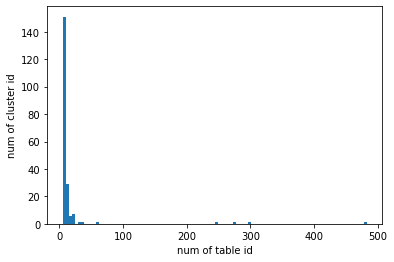

In [52]:
distribution = df_tel_grouped[df_tel_grouped['telephone_new']!='13126466365']['table id']
plt.hist(distribution[:200], bins=100)

plt.xlabel('num of table id')
plt.ylabel('num of cluster id')

### Additional Restrictions

### Name Similarity

In [54]:
# function for jaccard similarity calculation
def jaccard_distance(s1, s2):
    tokenized_s1 = set(s1.split(' '))
    tokenized_s2 = set(s2.split(' '))
    overlap = tokenized_s1.intersection(tokenized_s2) 
    union = tokenized_s1.union(tokenized_s2) 
    
    return len(overlap)/len(union)    

In [ ]:
# #function for simililarity calculation
# def calculate_bm25(query, corpus):
#     tokenized_corpus = [doc.split(" ") for doc in corpus]
#     bm25 = BM25Okapi(tokenized_corpus)
#     tokenized_query = query.split(" ")
#     doc_scores = bm25.get_scores(tokenized_query)
#     return doc_scores

#### matching using telephone

In [53]:
def jaccard_filter(df, col, par):
    tmp = df[df[col]==par]
    merged=tmp.merge(tmp, on=col)
    merged['jaccard'] = 0.0
    for idx, row in merged.iterrows():
        jaccard=jaccard_distance(row['name_x'], row['name_y'])
        merged.at[idx, 'jaccard']=jaccard
    return merged[merged['jaccard']>0.6]              # TODO: try lower jaccard threshold

In [55]:
telephone = df_tel_grouped[df_tel_grouped['name']>1]['telephone_new'] 

df_tel_jaccard_filtered = pd.DataFrame()
for par in telephone:
    tmp = jaccard_filter(df_tel_filtered[~df_tel_filtered['name'].isna()], 'telephone_new', par)
    df_tel_jaccard_filtered = pd.concat([df_tel_jaccard_filtered, tmp])

In [72]:
# show results -tel
cols_selected = ['name_x','name_y','table id_x','table id_y']
criteria = df_tel_jaccard_filtered['table id_x']!=df_tel_jaccard_filtered['table id_y']
df_tel_jaccard_filtered[criteria][cols_selected]

,name_x,name_y,table id_x,table id_y
3,C Fredrick Meine III Attorney At Law,C Fredrick Meine III Attorney At Law,LocalBusiness_101attorney.com_September2020,LocalBusiness_attorneyhelp.org_September2020
19,Paul M Parvanian Attorney At Law,Paul M Parvanian Attorney At Law,LocalBusiness_101attorney.com_September2020,LocalBusiness_attorneyhelp.org_September2020
21,C Fredrick Meine III Attorney At Law,C Fredrick Meine III Attorney At Law,LocalBusiness_attorneyhelp.org_September2020,LocalBusiness_101attorney.com_September2020
37,Paul M Parvanian Attorney At Law,Paul M Parvanian Attorney At Law,LocalBusiness_attorneyhelp.org_September2020,LocalBusiness_101attorney.com_September2020
6,Law Office Of Dean A Reed PA,Law Office Of Dean A Reed PA,LocalBusiness_101attorney.com_September2020,LocalBusiness_attorneyhelp.org_September2020
...,...,...,...,...
2,Law Office of Nicolas Leo Jr PC,Nicolas Leo Jr Law Office PC,LocalBusiness_attorneyhelp.org_September2020,LocalBusiness_101attorney.com_September2020
1,Wolff & Hislop Attorneys at Law,Wolff & Hislop Attorneys at Law,LocalBusiness_101attorney.com_September2020,LocalBusiness_attorneyhelp.org_September2020
2,Wolff & Hislop Attorneys at Law,Wolff & Hislop Attorneys at Law,LocalBusiness_attorneyhelp.org_September2020,LocalBusiness_101attorney.com_September2020
1,The Law Office of John R Carrozza PC,The Law Office of John R Carrozza PC,LocalBusiness_101attorney.com_September2020,LocalBusiness_attorneyhelp.org_September2020


#### matching using geo

In [57]:
def jaccard_filter2(df, col1, col2, par1, par2):
    tmp = df[(df[col1]==par1) & (df[col2]==par2)]
    merged=tmp.merge(tmp, on=[col1,col2])
    merged['jaccard'] = 0.0
    for idx, row in merged.iterrows():
        jaccard=jaccard_distance(row['name_x'], row['name_y'])
        merged.at[idx, 'jaccard']=jaccard
    return merged[merged['jaccard']>0.6]             # TODO: try lower jaccard threshold

In [58]:
geo=[]
for idx,row in df_geo_grouped[df_geo_grouped['name']>1][['longitude','latitude']].iterrows():
    a=row['longitude']
    b=row['latitude']
    geo.append((a,b))

In [59]:
df_geo_jaccard_filtered = pd.DataFrame()
for x in geo:
    par1 = x[0]
    par2 = x[1]
    tmp = jaccard_filter2(df_geo_filtered[~df_geo_filtered['name'].isna()], 'longitude','latitude', par1, par2)
    df_geo_jaccard_filtered = pd.concat([df_geo_jaccard_filtered, tmp])

In [67]:
# show results -geo
cols_selected = ['name_x','name_y','table id_x','table id_y']
criteria = df_geo_jaccard_filtered['table id_x']!=df_geo_jaccard_filtered['table id_y']
df_geo_jaccard_filtered[criteria][cols_selected]

,name_x,name_y,table id_x,table id_y
